# SplitRec：在隐语拆分学习中使用流水线并行

> 注意： 以下代码仅供演示用途，在演示过程中可能会揭露部分信息。请勿直接将此示例代码用于实际生产环境中。在实际部署前，请根据您的具体需求和安全标准进行必要的修改和调整。

> 本示例基于基于“拆分学习：银行营销”教程制作，建议先观看那个教程。

在拆分学习中，由于模型被拆分在多个设备当中，进行训练的时候，各方需要对中间结果和梯度进行多次传输，计算和网络通信存在大量 idle 时间，我们在隐语中参考论文[《PipeLearn: Pipeline Parallelism for 
Collaborative Machine Learnin》](https://arxiv.org/pdf/2302.12803.pdf)，利用隐语底座 RayFed 的任务调度能力，实现了流水线并行，使得计算和通信能够交叠隐藏部分计算时间，提高资源利用率。由于计算和通信的并发执行，使用流水线并行可能会带来模型准确性上的损失，用户可以根据实际场景平衡性能和精度。

下面我们通过一个例子来看一下如何使用在隐语拆分学习中使用流水线并行。

## 环境设置
首先，我们在 secretflow 环境中创造 2 个实体 alice 和 bob。

In [ ]:
import secretflow as sf

try:
    sf.shutdown()
except TypeError:
    print("Clean up the environment")
sf.init(['alice', 'bob'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')

2023-09-26 19:49:23,600	INFO worker.py:1538 -- Started a local Ray instance.


## 准备数据
接下来我们准备要学习的数据。

我们使用“拆分学习：银行营销”中的数据准备和处理方法，下载银行营销数据集并进行处理。alice 和 bob 的角色和之前的教程完全相同：

In [ ]:
from secretflow.utils.simulation.datasets import load_bank_marketing
from secretflow_fl.preprocessing.scaler_fl import MinMaxScaler
from secretflow_fl.preprocessing.encoder_fl import LabelEncoder
from secretflow.data.split import train_test_split

random_state = 1234

data = load_bank_marketing(parts={alice: (0, 4), bob: (4, 16)}, axis=1)
label = load_bank_marketing(parts={alice: (16, 17)}, axis=1)

encoder = LabelEncoder()
data['job'] = encoder.fit_transform(data['job'])
data['marital'] = encoder.fit_transform(data['marital'])
data['education'] = encoder.fit_transform(data['education'])
data['default'] = encoder.fit_transform(data['default'])
data['housing'] = encoder.fit_transform(data['housing'])
data['loan'] = encoder.fit_transform(data['loan'])
data['contact'] = encoder.fit_transform(data['contact'])
data['poutcome'] = encoder.fit_transform(data['poutcome'])
data['month'] = encoder.fit_transform(data['month'])
label = encoder.fit_transform(label)

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

train_data, test_data = train_test_split(
    data, train_size=0.8, random_state=random_state
)
train_label, test_label = train_test_split(
    label, train_size=0.8, random_state=random_state
)

## 定义模型结构

接下来我们创建联邦模型，同样地，我们使用“拆分学习：银行营销”中的建模，构建出 base_model 和 fuse_model，然后就可以定义 SLModel 用于训练：

In [3]:
def create_base_model(input_dim, output_dim, name='base_model'):
    # Create model
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        import tensorflow as tf

        model = keras.Sequential(
            [
                keras.Input(shape=input_dim),
                layers.Dense(100, activation="relu"),
                layers.Dense(output_dim, activation="relu"),
            ]
        )
        # Compile model
        model.summary()
        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=["accuracy", tf.keras.metrics.AUC()],
        )
        return model

    return create_model


# prepare model
hidden_size = 64

model_base_alice = create_base_model(4, hidden_size)
model_base_bob = create_base_model(12, hidden_size)


def create_fuse_model(input_dim, output_dim, party_nums, name='fuse_model'):
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        import tensorflow as tf

        # input
        input_layers = []
        for i in range(party_nums):
            input_layers.append(
                keras.Input(
                    input_dim,
                )
            )

        merged_layer = layers.concatenate(input_layers)
        fuse_layer = layers.Dense(64, activation='relu')(merged_layer)
        output = layers.Dense(output_dim, activation='sigmoid')(fuse_layer)

        model = keras.Model(inputs=input_layers, outputs=output)
        model.summary()

        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=["accuracy", tf.keras.metrics.AUC()],
        )
        return model

    return create_model


model_fuse = create_fuse_model(input_dim=hidden_size, party_nums=2, output_dim=1)

base_model_dict = {alice: model_base_alice, bob: model_base_bob}

## 定义 SLModel
这里如果使用流水线并行，设置 strategy = 'pipline'，并设置参数 pipeline_size，pipeline_size 增大并发程度会增大，但达到一定阈值，当一方的计算或网络被打满，性能将不会再有提升，通常 pipeline_size 设为 2-4。

In [4]:
from secretflow_fl.ml.nn import SLModel

sl_model_origin = SLModel(
    base_model_dict=base_model_dict,
    device_y=alice,
    model_fuse=model_fuse,
)

sl_model_pipeline = SLModel(
    base_model_dict=base_model_dict,
    device_y=alice,
    model_fuse=model_fuse,
    strategy='pipeline',
    pipeline_size=2,
)

(_run pid=1817588) /home/ssd2/zhaocaibei/miniconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
(_run pid=1817588)   warnings.warn(
(_run pid=1817882) /home/ssd2/zhaocaibei/miniconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
(_run pid=1817882)   warnings.warn(
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party alice.
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.sl.backend.tensorflow.sl_base.PYUSLTFModel'> with party bob.
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.sl.backend.tensorflow.strategy.pipeline.PYUPipelineTFModel'> with party alice.
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.sl.backend.tensorflow.strategy.pipeline.PYUPipelineTFModel'> with party bob.


## 开始训练

我们分别对没有使用通讯压缩的模型和使用了量化压缩的模型进行训练，并把训练轮次拉高到40轮，看看效果如何。

In [5]:
import time

histories = []
cost_time = []
for sl_model in [sl_model_origin, sl_model_pipeline]:
    begin = time.time()
    history = sl_model.fit(
        train_data,
        train_label,
        validation_data=(test_data, test_label),
        epochs=40,
        batch_size=128,
        shuffle=True,
        verbose=1,
        validation_freq=1,
    )
    end = time.time()
    cost_time.append((end - begin) / 60)
    histories.append(history)

print(cost_time)

INFO:root:SL Train Params: {'x': VDataFrame(partitions={PYURuntime(alice): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f13d0aa04c0>, PYURuntime(bob): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f136874bcd0>}, aligned=True), 'y': VDataFrame(partitions={PYURuntime(alice): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f13d0ac8430>}, aligned=True), 'batch_size': 128, 'epochs': 40, 'verbose': 1, 'callbacks': None, 'validation_data': (VDataFrame(partitions={PYURuntime(alice): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f136874bc10>, PYURuntime(bob): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f136874b400>}, aligned=True), VDataFrame(partitions={PYURuntime(alice): <secretflow.data.partition.pandas.partition.PdPartition object at 0x7f136874be20>}, aligned=True)), 'shuffle': True, 'sample_weight': None, 'validation_freq': 1, 'dp_spent_step_freq': None, 'dataset_builder': No

(PYUSLTFModel pid=1825002) Model: "sequential"
(PYUSLTFModel pid=1825002) _________________________________________________________________
(PYUSLTFModel pid=1825002)  Layer (type)                Output Shape              Param #   
(PYUSLTFModel pid=1825002) =================================================================
(PYUSLTFModel pid=1825002)  dense (Dense)               (None, 100)               500       
(PYUSLTFModel pid=1825002)                                                                  
(PYUSLTFModel pid=1825002)  dense_1 (Dense)             (None, 64)                6464      
(PYUSLTFModel pid=1825002)                                                                  
(PYUSLTFModel pid=1825002) =================================================================
(PYUSLTFModel pid=1825002) Total params: 6,964
(PYUSLTFModel pid=1825002) Trainable params: 6,964
(PYUSLTFModel pid=1825002) Non-trainable params: 0
(PYUSLTFModel pid=1825002) _________________________________

  0%|          | 0/29 [00:00<?, ?it/s](PYUPipelineTFModel pid=1825145) 2023-09-26 19:49:39.329376: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/gcc-toolset-11/root/usr/lib64:/opt/rh/gcc-toolset-11/root/usr/lib:/opt/rh/gcc-toolset-11/root/usr/lib64/dyninst:/opt/rh/gcc-toolset-11/root/usr/lib/dyninst
(PYUPipelineTFModel pid=1825145) 2023-09-26 19:49:39.329425: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


(PYUPipelineTFModel pid=1825145) Model: "sequential"
(PYUPipelineTFModel pid=1825145) _________________________________________________________________
(PYUPipelineTFModel pid=1825145)  Layer (type)                Output Shape              Param #   
(PYUPipelineTFModel pid=1825145) =================================================================
(PYUPipelineTFModel pid=1825145)  dense (Dense)               (None, 100)               500       
(PYUPipelineTFModel pid=1825145)                                                                  
(PYUPipelineTFModel pid=1825145)  dense_1 (Dense)             (None, 64)                6464      
(PYUPipelineTFModel pid=1825145)                                                                  
(PYUPipelineTFModel pid=1825145) =================================================================
(PYUPipelineTFModel pid=1825145) Total params: 6,964
(PYUPipelineTFModel pid=1825145) Trainable params: 6,964
(PYUPipelineTFModel pid=1825145) Non-trainabl

(PYUPipelineTFModel pid=1825269) 2023-09-26 19:49:39.538987: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/gcc-toolset-11/root/usr/lib64:/opt/rh/gcc-toolset-11/root/usr/lib:/opt/rh/gcc-toolset-11/root/usr/lib64/dyninst:/opt/rh/gcc-toolset-11/root/usr/lib/dyninst
(PYUPipelineTFModel pid=1825269) 2023-09-26 19:49:39.539186: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


(PYUPipelineTFModel pid=1825145) Model: "model"
(PYUPipelineTFModel pid=1825145) __________________________________________________________________________________________________
(PYUPipelineTFModel pid=1825145)  Layer (type)                   Output Shape         Param #     Connected to                     
(PYUPipelineTFModel pid=1825145) ==================================================================================================
(PYUPipelineTFModel pid=1825145)  input_2 (InputLayer)           [(None, 64)]         0           []                               
(PYUPipelineTFModel pid=1825145)                                                                                                   
(PYUPipelineTFModel pid=1825145)  input_3 (InputLayer)           [(None, 64)]         0           []                               
(PYUPipelineTFModel pid=1825145)                                                                                                   
(PYUPipelineTFModel pid=1825

  7%|▋         | 2/29 [00:02<00:38,  1.43s/it](_run pid=1817588) 2023-09-26 19:49:42.338308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/gcc-toolset-11/root/usr/lib64:/opt/rh/gcc-toolset-11/root/usr/lib:/opt/rh/gcc-toolset-11/root/usr/lib64/dyninst:/opt/rh/gcc-toolset-11/root/usr/lib/dyninst
(_run pid=1817588) 2023-09-26 19:49:43.232958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/gcc-toolset-11/root/usr/lib64:/opt/rh/gcc-toolset-11/root/usr/lib:/opt/rh/gcc-toolset-11/root/usr/lib64/dyninst:/opt/rh/gcc-toolset-11/root/usr/lib/dyninst
(_run pid=1817588) 2023-09-26 19:49:43.233049: W tensorflow/compiler/x

[1.012537411848704, 0.7321080048878987]


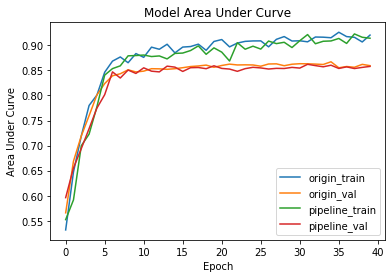

In [6]:
import matplotlib.pyplot as plt

for history in histories:
    plt.plot(history['train_auc_1'])
    plt.plot(history['val_auc_1'])

plt.title('Model Area Under Curve')
plt.ylabel('Area Under Curve')
plt.xlabel('Epoch')
plt.legend(
    ['origin_train', 'origin_val', 'pipeline_train', 'pipeline_val'], loc='lower right'
)
plt.show()

可以看到，两个模型的验证集 auc 均在 0.85 左右波动，使用流水线并行对此任务的训练精度影响不大，而训练时间由 0.76 分钟下降到 0.65 分钟。

## 总结

本篇示例介绍了隐语拆分学习中流水线并行的使用方法。与一般拆分学习的使用方法一样，只需在定义 SLModel 时指定 strategy='pipeline' 并设置 pipeline_num 即可。